# Lab 2 – ROI & Mask Refinement & BEV

Trong lab này, chúng ta thực hành hai bước đầu tiên trong pipeline bám làn của dự án:

1. Áp dụng ROI (Region of Interest) để chỉ giữ lại vùng mặt đường phía trước xe.
2. Lọc nhiễu và làm sạch mask làn đường (mask refinement) để có một vùng làn liên tục, rõ ràng.
 
> model sinh ra lane mask → áp dụng ROI → refine mask → BEV + scanline → controller.


#### Tại sao cần ROI & mask refinement?

- Model segmentation thường dự đoán cả những vùng ngoài mặt đường (nhiễu, phản xạ, bóng người…).
- Nếu ta đem mask thô này đi tính hình học (centerline, curvature, heading), controller sẽ bị:
  - Nhảy loạn sang vùng nhiễu,
  - Đánh lái giật cục,
  - Xe mất ổn định.

Vì vậy, trước khi tới bước hình học, ta luôn cần:

1. Giới hạn vùng quan tâm (ROI) ở chỗ mặt đường.
2. Làm sạch mask để chỉ còn một vùng làn rõ ràng, liên tục.


### 1. Cài đặt môi trường
Trong bài lab này chúng ta sử dụng OpenCV (`cv2`) và NumPy. Chạy ô sau để import các thư viện cần thiết.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### 2. Tải mặt nạ mẫu
Trong thực tế, mặt nạ làn đường nhị phân đến từ mô hình phân đoạn bằng mạng nơ-ron. Trong bài lab này, bạn hãy chuẩn bị một ảnh mặt nạ nhị phân (giá trị 0 hoặc 1) và đặt vào thư mục `data/`. Mã dưới đây sẽ load ảnh đó vào mảng NumPy.

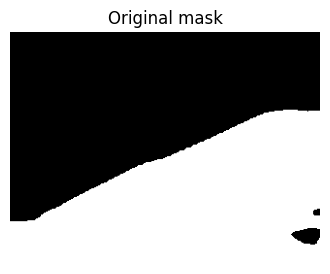

In [2]:
# TODO: provide the path to your sample mask image (grayscale PNG or JPG)
mask_path = r"D:\DATA\Test_datalab\frame_00250_1_mask_raw.png"  # e.g. 'data/lane_mask.png'

# Load the mask image as grayscale
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
if mask is None:
    raise FileNotFoundError('Mask file not found. Please place a binary mask image in the data/ folder.')

# Convert mask to binary 0/1
mask01 = (mask > 0).astype(np.uint8)

# Display the original mask
plt.figure(figsize=(4, 4))
plt.title('Original mask')
plt.imshow(mask01, cmap='gray')
plt.axis('off')
plt.show()

## Phần 1 – Áp dụng ROI (Region of Interest)

### 1. Ý tưởng trực quan

Camera gắn trên AutoCar-Kit có góc nhìn thấp. Trong ảnh:

- Phần trên thường là trần nhà, tường, người, chân bàn…
- Phần dưới mới là mặt đường và vạch làn.

Đối với bài toán giữ làn, chúng ta chỉ cần vùng gần xe – tức là chỉ giữ lại đa giác 40% dưới cùng nơi làn đường thực sự xuất hiện. 
Thay vì xử lý toàn bộ ảnh, ta cắt một vùng ROI (Region of Interest):

> ROI = đa giác bao trùm khu vực mặt đường mà ta quan tâm.

Trong pipeline chính, ROI được định nghĩa bằng các toạ độ tỉ lệ (ratio) so với kích thước ảnh, ví dụ:

```python
roi_poly = np.float32([
    [0.03, 0.58],
    [0.97, 0.58],
    [0.97, 0.99],
    [0.03, 0.99],
])


### 2. Biểu diễn toán học của ROI

Giả sử ảnh đầu ra của mô hình segmentation có kích thước $(H \times W)$.  
Ta ký hiệu:

- $M(x, y)$: giá trị của mask làn đường tại pixel $(x,y)$, trong đó $M(x,y) \in \{0,1\}$.
- $(x_i^{\text{ratio}},\, y_i^{\text{ratio}})$: tọa độ tỉ lệ của các đỉnh đa giác ROI, trong đó mỗi giá trị thuộc $[0,1]$.

##### Chuyển tọa độ tỉ lệ → tọa độ pixel

Để chuyển các điểm ROI về tọa độ pixel thực trong ảnh, ta nhân với chiều cao và chiều rộng:

$$
x_i^{\text{pix}}
= x_i^{\text{ratio}} \cdot W, 
\qquad
y_i^{\text{pix}}
= y_i^{\text{ratio}} \cdot H.
$$

Điều này đảm bảo rằng ROI luôn độc lập với độ phân giải ảnh, và chỉ thay đổi theo kích thước thật $(W, H)$.


### 3. Xây dựng mặt nạ ROI

Ta định nghĩa hàm nhị phân $R(x,y)$ — mặt nạ ROI — như sau:

$$
R(x,y) =
\begin{cases}
1, & \text{nếu } (x,y) \text{ nằm trong đa giác ROI}, \\
0, & \text{nếu } (x,y) \text{ nằm ngoài ROI}. 
\end{cases}
$$

Hàm này được tạo bằng cách tô đầy đa giác ROI trên một ảnh rỗng.


### 4. Áp dụng ROI lên mask làn đường

Mask sau khi áp dụng ROI chính là phép nhân điểm–điểm giữa mask gốc và mặt nạ ROI:

$$
M_{\text{ROI}}(x,y)
= M(x,y) \cdot R(x,y).
$$

Ý nghĩa:

- Nếu $(x,y)$ nằm ngoài ROI  
  ⇒ $R(x,y)=0$  
  ⇒ pixel bị loại bỏ.

- Nếu $(x,y)$ nằm trong ROI 
  ⇒ $R(x,y)=1$  
  ⇒ giá trị mask giữ nguyên.



### 5. Minh hoạ

Áp dụng ROI giúp:

- Loại bỏ toàn bộ phần trên ảnh (nơi không có mặt đường).
- Giảm nhiễu từ vật thể, ánh sáng, bóng người.
- Làm pipeline phía sau (refine mask → BEV → scanline → controller) ổn định hơn.

ROI đóng vai trò như một bộ lọc không gian, chỉ giữ lại những gì xe thực sự quan tâm.


##### ROI Filterting 
![ROI Filtering](ROI.png)  

### 6. Thực hành – Áp dụng ROI

In [ ]:
import numpy as np
import cv2

def apply_roi(mask01: np.ndarray, roi_poly: np.ndarray) -> np.ndarray:
    # Scale ROI polygon to pixel coordinates
    H, W = mask01.shape
    pts = (roi_poly * np.array([W, H], dtype=np.float32)).astype(np.int32)

    # Create a mask and fill the ROI polygon with ones
    roi_mask = np.zeros_like(mask01, dtype=np.uint8)
    cv2.fillPoly(roi_mask, [pts], 1)

    # Set pixels outside the ROI to zero
    mask_roi = mask01.copy()
    mask_roi[roi_mask == 0] = 0
    return mask_roi

# Define a default ROI polygon similar to the lane pipeline
roi_poly = np.float32([[0.03, 0.58], [0.97, 0.58], [0.97, 0.99], [0.03, 0.99]])
mask_roi = apply_roi(mask01, roi_poly)

# Display the result
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('Original mask')
plt.imshow(mask01, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Mask after ROI')
plt.imshow(mask_roi, cmap='gray')
plt.axis('off')

plt.show()

## Phần 2 – Lọc nhiễu Mask (Mask Refinement)

Sau khi áp dụng ROI, mask làn đường vẫn thường chứa nhiều lỗi do mô hình dự đoán:

- Làn bị đứt đoạn (gaps),
- Xuất hiện đốm trắng nhỏ (noise),
- Có nhiều vùng rời rạc không phải làn thật.

Mục tiêu của bước mask refinement là:

> Biến mask thô ban đầu thành một vùng làn duy nhất – sạch – liên tục – ổn định cho bước hình học (geometry).

Để làm điều đó, pipeline thực hiện 3 thao tác chính:
1. Chuẩn hóa mask về dạng nhị phân {0,1}  
2. Áp dụng morphological closing để nối liền làn đường  
3. Giữ lại vùng (contour) có diện tích lớn nhất


### 1. Chuẩn hóa mask về dạng nhị phân

Trong nhiều trường hợp, mô hình có thể trả về mask với các giá trị khác nhau (0 hoặc >0).  
Ta quy về dạng nhị phân:

$$
m(x,y) =
\begin{cases}
1, & \text{khi } M(x,y) > 0, \\
0, & \text{ngược lại}.
\end{cases}
$$

Điều này giúp đảm bảo mask luôn là dữ liệu "sạch" trước khi thực hiện các phép toán hình thái học.


### 2. Morphological Closing – Nối các đoạn làn bị đứt

####  Định nghĩa toán học

Phép closing của ảnh nhị phân $(m)$ với kernel $(K)$ là:

$$
m \bullet K = (m \oplus K) \ominus K
$$

Trong đó:

- $(m \oplus K)$: dilation – giãn vùng trắng (kết nối các điểm gần nhau)  
- $(m \ominus K)$: erosion – co vùng trắng lại (loại bỏ phình ra do dilation)

Ý nghĩa trực quan:

> Dilation lấp các khoảng trống nhỏ → Erosion thu lại → kết quả giữ nguyên đường nét lớn nhưng không còn khe hở nhỏ.


####  Kernel dọc (5 × 25)

Pipeline sử dụng kernel:

- Rộng 5 pixel → không làm hai làn kế bên bị dính vào nhau  
- Cao 25 pixel → đủ dài để nối các khoảng đứt đoạn theo hướng dọc (hướng lane)

Kernel:

```python
ker_vertical = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 25))


##### Mask Refinement 
![Mask Refinement](mask_refinement.jpg)

### 3. Thực hành – Lọc nhiễu

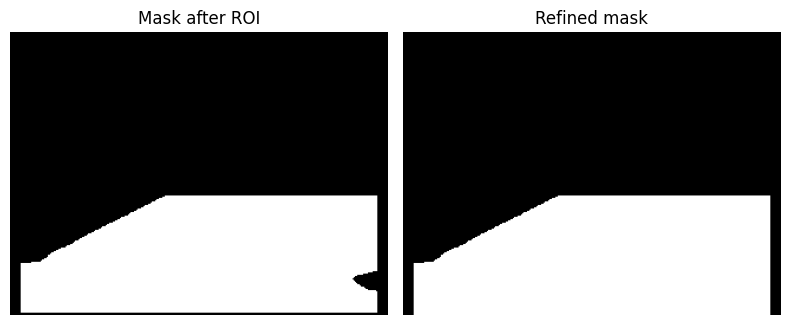

In [4]:
import numpy as np
import cv2

def refine_mask01(mask01: np.ndarray) -> np.ndarray:
    # Convert mask to uint8 with values 0 or 255
    mask_uint8 = (mask01 * 255).astype(np.uint8)

    # Apply morphological closing to fill small gaps
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 25))
    closed = cv2.morphologyEx(mask_uint8, cv2.MORPH_CLOSE, kernel)

    # Remove small connected components (keep the largest two)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(closed)
    areas = stats[1:, cv2.CC_STAT_AREA]
    sorted_idx = areas.argsort()[::-1]
    mask_filtered = np.zeros_like(closed)
    for i in sorted_idx[:2]:
        comp_label = i + 1
        mask_filtered[labels == comp_label] = 255
    refined = (mask_filtered > 0).astype(np.uint8)
    return refined

# Apply refine_mask01 to the ROI mask
refined_mask = refine_mask01(mask_roi)

# Display the refined mask
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title('Mask after ROI')
plt.imshow(mask_roi, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Refined mask')
plt.imshow(refined_mask, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

### 4. Lưu ảnh

In [5]:
import os
import cv2
import time

# mask_refined: the final refined mask (binary 0/1 or 0/255)

# 1) Create the folder result_refine if it does not already exist
save_dir = "result_refine"
os.makedirs(save_dir, exist_ok=True)

# 2) Generate an output filename using a timestamp to avoid overwriting
filename = f"refined_{int(time.time())}.png"
save_path = os.path.join(save_dir, filename)

# 3) Convert the mask to 0–255 format before saving
mask_to_save = (refined_mask * 255).astype("uint8")

# 4) Save the image
cv2.imwrite(save_path, mask_to_save)

print("Refined mask has been saved at:", save_path)



Ảnh refine đã được lưu tại: result_refine\refined_1765424682.png


### Tổng kết
Trong bài lab này, bạn đã triển khai hai bước tiền xử lý quan trọng cho mặt nạ phân đoạn làn đường: áp dụng vùng quan tâm và tinh chỉnh mặt nạ bằng các phép toán hình thái. Mặt nạ sạch là cơ sở để tính toán hình học chính xác và điều khiển làn đường ổn định.